In [6]:
import shutil
import pickle
import os
import pandas as pd
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation 
from tensorflow.keras import initializers
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from tensorflow.keras.layers import Dense,Input,Conv1D,MaxPooling1D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import random as rn
import keras
import os
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score

In [7]:
data = pd.read_csv('preprocessed_data2.csv')

In [8]:
data.head(3)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.60
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.00
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,"My students need shine guards, athletic socks,...",1,0,"\r\n\""True champions aren't always the ones th...",516.85


In [9]:
X = data.drop(columns='project_is_approved')
Y = data['project_is_approved']

In [10]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y)

In [11]:
#max_review_length for essay data
essay_length = []
for i in X_train['essay']:
  essay_length.append(len(i.split()))
max_review_length_essay = max(essay_length)
print(f'maximum essay length is {max_review_length_essay}')

#max_review_length for project_title data
title_length = []
for i in X_train['project_title']:
  title_length.append(len(i.split()))
max_review_length_title = max(title_length)
print(f'maximum project_title length is {max_review_length_title}')

#max_review_length for project_title data
summary_length = []
for i in X_train['project_resource_summary']:
  summary_length.append(len(i.split()))
max_review_length_summary = max(summary_length)
print(f'maximum project_resource_summary length is {max_review_length_summary}')

maximum essay length is 504
maximum project_title length is 13
maximum project_resource_summary length is 137


In [12]:
#pading for project_title
unique_word = set()
for i in X_train['project_title']:
  for word in i.split():
    unique_word.add(word)
word_and_index_title = {word:j for j,word in enumerate(list(unique_word))}

title_one_hot_encoding = []
for i in X_train['project_title']:
  l = []
  for word in i.split():
    if word in word_and_index_title:
      l.append(word_and_index_title[word])
  title_one_hot_encoding.append(l)

padded_project_title = sequence.pad_sequences(title_one_hot_encoding, maxlen=max_review_length_title, padding='post')      


In [13]:
#pading for project_resource_summary
unique_word = set()
for i in X_train['project_resource_summary']:
  for word in i.split():
    unique_word.add(word)
word_and_index_summary = {word:j for j,word in enumerate(list(unique_word))}

summary_one_hot_encoding = []
for i in X_train['project_resource_summary']:
  l = []
  for word in i.split():
    if word in word_and_index_summary:
      l.append(word_and_index_summary[word])
  summary_one_hot_encoding.append(l)

padded_project_summary = sequence.pad_sequences(summary_one_hot_encoding, maxlen=max_review_length_summary, padding='post') 

In [14]:
#list for teacher_prefix
unique_word = set()
for i in X_train['teacher_prefix']:
  for word in i.split():
    unique_word.add(word)
word_and_index_teacher = {word:j for j,word in enumerate(list(unique_word))}

X_train_teacher_prefix_one_hot_encoding = []
for i in X_train['teacher_prefix']:
  l = []
  for word in i.split():
    if word in word_and_index_teacher:
      l.append(word_and_index_teacher[word])
  X_train_teacher_prefix_one_hot_encoding.append(l)

X_test_teacher_prefix_one_hot_encoding = []
for i in X_test['teacher_prefix']:
  l = []
  for word in i.split():
    if word in word_and_index_teacher:
      l.append(word_and_index_teacher[word])
  X_test_teacher_prefix_one_hot_encoding.append(l)  

In [15]:
#list for school_state
unique_word = set()
for i in X_train['school_state']:
  for word in i.split():
    unique_word.add(word)
word_and_index_school = {word:j for j,word in enumerate(list(unique_word))}

X_train_school_state_one_hot_encoding = []
for i in X_train['school_state']:
  l = []
  for word in i.split():
    if word in word_and_index_school:
      l.append(word_and_index_school[word])
  X_train_school_state_one_hot_encoding.append(l)


X_test_school_state_one_hot_encoding = []
for i in X_test['school_state']:
  l = []
  for word in i.split():
    if word in word_and_index_school:
      l.append(word_and_index_school[word])
  X_test_school_state_one_hot_encoding.append(l)

In [16]:
#list for project_grade_category
unique_word = set()
for i in X_train['project_grade_category']:
  for word in i.split():
    unique_word.add(word)
word_and_index_grade = {word:j for j,word in enumerate(list(unique_word))}

X_train_project_grade_category_one_hot_encoding = []
for i in X_train['project_grade_category']:
  l = []
  for word in i.split():
    if word in word_and_index_grade:
      l.append(word_and_index_grade[word])
  X_train_project_grade_category_one_hot_encoding.append(l)


X_test_project_grade_category_one_hot_encoding = []
for i in X_test['project_grade_category']:
  l = []
  for word in i.split():
    if word in word_and_index_grade:
      l.append(word_and_index_grade[word])
  X_test_project_grade_category_one_hot_encoding.append(l)  

In [17]:
#list for project_subject_categories
unique_word = set()
for i in X_train['project_subject_categories']:
  for word in i.split():
    unique_word.add(word)
word_and_index_subject = {word:j for j,word in enumerate(list(unique_word))}

X_train_project_subject_categories_one_hot_encoding = []
for i in X_train['project_subject_categories']:
  l = []
  for word in i.split():
    if word in word_and_index_subject:
      l.append(word_and_index_subject[word])
  X_train_project_subject_categories_one_hot_encoding.append(l)

X_test_project_subject_categories_one_hot_encoding = []
for j in X_test['project_subject_categories']:
  l = []
  for word in j.split():
    if word in word_and_index_subject:
      l.append(word_and_index_subject[word])
    else:
      l.append(0)
  X_test_project_subject_categories_one_hot_encoding.append(l) 



In [18]:
#list for project_subject_subcategories
unique_word = set()
for i in X_train['project_subject_subcategories']:
  for word in i.split():
    unique_word.add(word)
word_and_index_sub = {word:j for j,word in enumerate(list(unique_word))}

X_train_project_subject_subcategories_one_hot_encoding = []
for i in X_train['project_subject_subcategories']:
  l = []
  for word in i.split():
    if word in word_and_index_sub:
      l.append(word_and_index_sub[word])
  X_train_project_subject_subcategories_one_hot_encoding.append(l)

X_test_project_subject_subcategories_one_hot_encoding = []
for i in X_test['project_subject_subcategories']:
  l = []
  for word in i.split():
    if word in word_and_index_sub:
      l.append(word_and_index_sub[word])
    else:
      l.append(0)  
  X_test_project_subject_subcategories_one_hot_encoding.append(l)  

In [19]:
tnop = []
price = []
for i , row in X_train.iterrows():
  tnop.append(int(row['teacher_number_of_previously_posted_projects'])) 
  price.append(int(row['price']))

X_train_numeracal_matrix = np.zeros((len(X_train),2))
for i in range(len(X_train)):
  X_train_numeracal_matrix[i][0] = tnop[i]
  X_train_numeracal_matrix[i][1] = price[i]


norm_X_train_numeracal_matrix = normalize(X_train_numeracal_matrix, axis=1)

In [20]:
tnop = []
price = []
for i , row in X_test.iterrows():
  tnop.append(int(row['teacher_number_of_previously_posted_projects'])) 
  price.append(int(row['price']))

X_test_numeracal_matrix = np.zeros((len(X_test),2))
for i in range(len(X_test)):
  X_test_numeracal_matrix[i][0] = tnop[i]
  X_test_numeracal_matrix[i][1] = price[i]

norm_X_test_numeracal_matrix = normalize(X_test_numeracal_matrix, axis=1)  
print(len(tnop),len(price))

15000 15000


In [21]:
tnop = []
price = []
for i , row in X_test.iterrows():
  if row['price'] is not None:
    tnop.append(row['price']) 
print(len(tnop))    

15000


In [22]:
tnop = []
price = []
for i , row in X_test.iterrows():
  if row['teacher_number_of_previously_posted_projects'] is not None:
    tnop.append(row['teacher_number_of_previously_posted_projects']) 
  price.append(row['price'])

X_test_numeracal_matrix = np.zeros((len(X_test),2))
for i in range(len(X_test)):
  X_test_numeracal_matrix[i][0] = tnop[i]
  X_test_numeracal_matrix[i][1] = price[i]

norm_X_test_numeracal_matrix = normalize(X_test_numeracal_matrix, axis=1)  
print(len(tnop),len(price))

15000 15000


In [23]:
Y_train = tf.keras.utils.to_categorical(y_train, 2) 
Y_test = tf.keras.utils.to_categorical(y_test, 2)

In [26]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# prepare tokenizer
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(X_train['essay'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
X_train_encoded_essay = t.texts_to_sequences(X_train['essay'])

X_test_encoded_essay = t.texts_to_sequences(X_test['essay'])
# pad documents to a max length of 4 words
max_length = max_review_length_essay
X_train_padded_essay = sequence.pad_sequences(X_train_encoded_essay, maxlen=max_length, padding='post')
X_test_padded_essay = sequence.pad_sequences(X_test_encoded_essay, maxlen=max_length, padding='post')

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
 model = pickle.load(f)
 embeddings_index = dict(zip(model.keys(),model.values()))
 f.close()

print('Loaded %s word vectors.' % len(embeddings_index))
#create a weight matrix for words in training docs
#each word is of 300 dimension
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Loaded %s word vectors.' % len(embedding_matrix))    


Loaded 51510 word vectors.
Loaded 46337 word vectors.


## MODEL :- 1

In [27]:
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

embedding_vecor_length = 30



inputs_essay = Input(shape=(max_review_length_essay,),)
inputs_school_state = Input(shape=(1,),)
inputs_project_grade_category = Input(shape=(1,), )
inputs_project_subject_categories = Input(shape=(1,), )
inputs_project_subject_subcategories = Input(shape=(1,), )
inputs_teacher_prefix = Input(shape=(1,), )
inputs_numerical = Input(shape=(2,), )

lstm = LSTM(units = 100 ,activation="tanh",kernel_initializer=tf.keras.initializers.he_uniform(seed=0),return_sequences=True)


essay_embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_review_length_essay, trainable=True)(inputs_essay)
lstm_output   = lstm(essay_embedding)
glo_avg = tf.keras.layers.GlobalAveragePooling1D()(lstm_output)
flatten_essay = Flatten()(glo_avg)

school_state_embedding = Embedding(len(word_and_index_school), 2, input_length=1)(inputs_school_state)
flatten_school_state = Flatten()(school_state_embedding)

project_grade_category_embedding = Embedding(len(word_and_index_grade), 2, input_length=1)(inputs_project_grade_category)
flatten_project_grade_category = Flatten()(project_grade_category_embedding)

project_subject_categories_embedding = Embedding(len(word_and_index_subject), 2, input_length=1)(inputs_project_subject_categories)
flatten_project_subject_categories = Flatten()(project_subject_categories_embedding)

project_subject_subcategories_embedding = Embedding(len(word_and_index_sub), 2, input_length=1)(inputs_project_subject_subcategories)
flatten_project_subject_subcategories = Flatten()(project_subject_subcategories_embedding)

teacher_prefix_embedding = Embedding(len(word_and_index_teacher), 2, input_length=1)(inputs_teacher_prefix)
flatten_teacher_prefix = Flatten()(teacher_prefix_embedding)

dense_numerical = Dense(1, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(inputs_numerical)

combine_con1 = keras.layers.concatenate([flatten_essay, flatten_school_state,flatten_project_grade_category,
                                         flatten_project_subject_categories,flatten_project_subject_subcategories,
                                         flatten_teacher_prefix,dense_numerical])


dense1 = Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(combine_con1)

drop_out1 = Dropout(0.1)(dense1)

dense2 = Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(drop_out1)

drop_out2 = Dropout(0.1)(dense2)

dense3 = Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(drop_out2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(dense3)

#Creating a model
model = Model(inputs=[inputs_essay, inputs_school_state,inputs_project_grade_category,inputs_project_subject_categories,
                      inputs_project_subject_subcategories,inputs_teacher_prefix,inputs_numerical],outputs=Out)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 504)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 504, 300)     13901100    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 504, 100)     160400      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [32]:
from sklearn.metrics import roc_auc_score
class f1_score_and_auc_Callback(tf.keras.callbacks.Callback):

    def  on_train_begin(self,logs={}):
      self.auc_score=[]

    def on_epoch_end(self, epoch, logs=None):
      y_pred_=self.model.predict(x_test)
      y_true=Y_test
      Auc_score  = roc_auc_score(y_true, y_pred_,average='samples')

      
      self.auc_score.append(Auc_score)
      print(" auc score :",Auc_score)

metrics=f1_score_and_auc_Callback()

In [33]:
opt = tf.keras.optimizers.RMSprop()
model.compile(loss = "categorical_crossentropy", optimizer = opt)

In [34]:
#np.asarray(x).astype('float32').
#all train features
e = np.asarray(X_train_padded_essay).astype(np.float32)
s = np.asarray(X_train_school_state_one_hot_encoding).astype(np.float32)
p = np.asarray(X_train_project_grade_category_one_hot_encoding).astype(np.float32)
ps = np.asarray(X_train_project_subject_categories_one_hot_encoding).astype(np.float32)
psu = np.asarray(X_train_project_subject_subcategories_one_hot_encoding).astype(np.float32)
t = np.asarray(X_train_teacher_prefix_one_hot_encoding).astype(np.float32)
n = np.asarray(norm_X_train_numeracal_matrix).astype(np.float32)

x_train = [e,s,p,ps,psu,t,n]
print(len(e),len(s),len(p),len(ps),len(psu),len(t),len(n))


#all test features
e1 = np.asarray(X_test_padded_essay).astype(np.float32)
s1 = np.asarray(X_test_school_state_one_hot_encoding).astype(np.float32)
p1 = np.asarray(X_test_project_grade_category_one_hot_encoding).astype(np.float32)
ps1 = np.asarray(X_test_project_subject_categories_one_hot_encoding).astype(np.float32)
psu1 = np.asarray(X_test_project_subject_subcategories_one_hot_encoding).astype(np.float32)
t1 = np.asarray(X_test_teacher_prefix_one_hot_encoding).astype(np.float32)
n1 = np.asarray(norm_X_test_numeracal_matrix).astype(np.float32)

x_test = [e1,s1,p1,ps1,psu1,t1,n1]
print(len(e1),len(s1),len(p1),len(ps1),len(psu1),len(t1),len(n1))


45000 45000 45000 45000 45000 45000 45000
15000 15000 15000 15000 15000 15000 15000


In [35]:
model.fit(x_train,Y_train,epochs=2,validation_data=(x_test ,Y_test),callbacks=metrics)

Epoch 1/2
1407/1407 [==============================] - 146s 80ms/step - loss: 0.4144 - val_loss: 0.3745
 auc score : 0.8502
Epoch 2/2
1407/1407 [==============================] - 112s 80ms/step - loss: 0.3676 - val_loss: 0.3707
 auc score : 0.8486


## MODEL :- 2

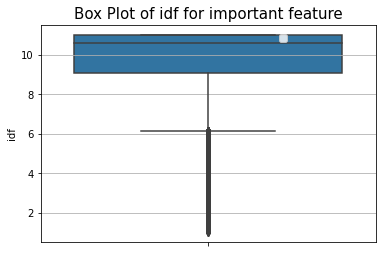

In [36]:

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn  as sns
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['essay'])
word_dic = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))

df = pd.DataFrame({'word':vectorizer.get_feature_names(),'idf':vectorizer.idf_})

import warnings
warnings.filterwarnings('ignore')
plt.title("Box Plot of idf for important feature",fontsize=15)
plt.grid()
ax=sns.boxplot(y='idf', data=df)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.75, 0.98))
plt.show()

In [37]:
#we are sorting idf value in descending order of top 50 idf values
vocab = sorted(word_dic.items(), key = lambda d:(d[1], d[0]))
vocab = { i[0]:i[1] for i in vocab}
print(len(vocab))

42424


In [38]:
word_list = []
for i in word_dic.items():
  if i[1] >9 and i[1] <11:
    word_list.append(i[0])

In [39]:
print(len(word_list))

15667


In [ ]:
from tqdm import tqdm
X_train_essay_list = []
for i, row in X_train.iterrows():
  l = []
  for word in row['essay'].split():
    if word in word_list:
      l.append(word)
  X_train_essay_list.append(' '.join(l)) 
  

X_test_essay_list = []
for i, row in X_test.iterrows():
  l = []
  for word in row['essay'].split():
    if word in word_list:
      l.append(word)
  X_test_essay_list.append(' '.join(l))   

df1 = pd.DataFrame({'essay':X_train_essay_list})
df1.to_pickle('X_train_essay_imp_word')

df2 = pd.DataFrame({'essay':X_test_essay_list})
df2.to_pickle('X_test_essay_imp_word') 

In [41]:
X_train_essay = pd.read_pickle('X_train_essay_imp_word')
X_test_essay = pd.read_pickle('X_test_essay_imp_word')

In [45]:

#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# prepare tokenizer
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(X_train_essay['essay'])
vocab_size = len(t.word_index) + 1
print(f'vocal size {vocab_size}')
# integer encode the documents
X_train_encoded_essay = t.texts_to_sequences(X_train_essay['essay'])

X_test_encoded_essay = t.texts_to_sequences(X_test_essay['essay'])
# pad documents to a max length of 4 words
max_length = max_review_length_essay
X_train_padded_essay = sequence.pad_sequences(X_train_encoded_essay, maxlen=max_length, padding='post')
X_test_padded_essay = sequence.pad_sequences(X_test_encoded_essay, maxlen=max_length, padding='post')


with open('glove_vectors', 'rb') as f:
 model = pickle.load(f)
 embeddings_index = dict(zip(model.keys(),model.values()))
 f.close()

print('Loaded %s word vectors.' % len(embeddings_index))
#create a weight matrix for words in training docs
#each word is of 300 dimension
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Loaded %s word vectors.' % len(embedding_matrix))    

vocal size 10834
Loaded 51510 word vectors.
Loaded 10834 word vectors.


In [46]:
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

embedding_vecor_length = 30


inputs_essay = Input(shape=(max_review_length_essay,),)
inputs_school_state = Input(shape=(1,), )
inputs_project_grade_category = Input(shape=(1,), )
inputs_project_subject_categories = Input(shape=(1,), )
inputs_project_subject_subcategories = Input(shape=(1,),)
inputs_teacher_prefix = Input(shape=(1,), )
inputs_numerical = Input(shape=(2,), )

lstm = LSTM(units = 100 ,activation="tanh",return_sequences=True)


essay_embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_review_length_essay, trainable=True)(inputs_essay)
lstm_output   = lstm(essay_embedding)
glo_avg = tf.keras.layers.GlobalAveragePooling1D()(lstm_output)
flatten_essay = Flatten()(glo_avg)

school_state_embedding = Embedding(len(word_and_index_school), 2, input_length=1)(inputs_school_state)
flatten_school_state = Flatten()(school_state_embedding)

project_grade_category_embedding = Embedding(len(word_and_index_grade), 2, input_length=1)(inputs_project_grade_category)
flatten_project_grade_category = Flatten()(project_grade_category_embedding)

project_subject_categories_embedding = Embedding(len(word_and_index_subject), 2, input_length=1)(inputs_project_subject_categories)
flatten_project_subject_categories = Flatten()(project_subject_categories_embedding)

project_subject_subcategories_embedding = Embedding(len(word_and_index_sub), 2, input_length=1)(inputs_project_subject_subcategories)
flatten_project_subject_subcategories = Flatten()(project_subject_subcategories_embedding)

teacher_prefix_embedding = Embedding(len(word_and_index_teacher), 2, input_length=1)(inputs_teacher_prefix)
flatten_teacher_prefix = Flatten()(teacher_prefix_embedding)

dense_numerical = Dense(1, activation='relu')(inputs_numerical)

combine_con1 = keras.layers.concatenate([flatten_essay, flatten_school_state,flatten_project_grade_category,
                                         flatten_project_subject_categories,flatten_project_subject_subcategories,
                                         flatten_teacher_prefix,dense_numerical])


dense1 = Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(combine_con1)

drop_out1 = Dropout(0.1)(dense1)

dense2 = Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(drop_out1)

drop_out2 = Dropout(0.1)(dense2)

dense3 = Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(drop_out2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(dense3)

#Creating a model
model = Model(inputs=[inputs_essay, inputs_school_state,inputs_project_grade_category,inputs_project_subject_categories,
                      inputs_project_subject_subcategories,inputs_teacher_prefix,inputs_numerical],outputs=Out)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 504)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 504, 300)     3250200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 504, 100)     160400      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [48]:
opt = tf.keras.optimizers.RMSprop()
model.compile(loss = "categorical_crossentropy", optimizer = opt)

In [49]:
#np.asarray(x).astype('float32').
#all train features
e = np.asarray(X_train_padded_essay).astype(np.float32)
s = np.asarray(X_train_school_state_one_hot_encoding).astype(np.float32)
p = np.asarray(X_train_project_grade_category_one_hot_encoding).astype(np.float32)
ps = np.asarray(X_train_project_subject_categories_one_hot_encoding).astype(np.float32)
psu = np.asarray(X_train_project_subject_subcategories_one_hot_encoding).astype(np.float32)
t = np.asarray(X_train_teacher_prefix_one_hot_encoding).astype(np.float32)
n = np.asarray(norm_X_train_numeracal_matrix).astype(np.float32)

x_train = [e,s,p,ps,psu,t,n]
print(len(e),len(s),len(p),len(ps),len(psu),len(t),len(n))

#all test features
e1 = np.asarray(X_test_padded_essay).astype(np.float32)
s1 = np.asarray(X_test_school_state_one_hot_encoding).astype(np.float32)
p1 = np.asarray(X_test_project_grade_category_one_hot_encoding).astype(np.float32)
ps1 = np.asarray(X_test_project_subject_categories_one_hot_encoding).astype(np.float32)
psu1 = np.asarray(X_test_project_subject_subcategories_one_hot_encoding).astype(np.float32)
t1 = np.asarray(X_test_teacher_prefix_one_hot_encoding).astype(np.float32)
n1 = np.asarray(norm_X_test_numeracal_matrix).astype(np.float32)

x_test = [e1,s1,p1,ps1,psu1,t1,n1]
print(len(e1),len(s1),len(p1),len(ps1),len(psu1),len(t1),len(n1))

45000 45000 45000 45000 45000 45000 45000
15000 15000 15000 15000 15000 15000 15000


In [50]:
model.fit(x_train,Y_train,epochs=2,validation_data=(x_test ,Y_test),callbacks=metrics)

Epoch 1/2
1407/1407 [==============================] - 68s 47ms/step - loss: 0.4390 - val_loss: 0.4243
 auc score : 0.8476
Epoch 2/2
1407/1407 [==============================] - 65s 46ms/step - loss: 0.4195 - val_loss: 0.4213
 auc score : 0.8476


## MODEL :- 3

In [51]:
#all train features
e = np.asarray(X_train_padded_essay).astype(np.float32)
s = np.asarray(X_train_school_state_one_hot_encoding).astype(np.float32)
p = np.asarray(X_train_project_grade_category_one_hot_encoding).astype(np.float32)
ps = np.asarray(X_train_project_subject_categories_one_hot_encoding).astype(np.float32)
psu = np.asarray(X_train_project_subject_subcategories_one_hot_encoding).astype(np.float32)
t = np.asarray(X_train_teacher_prefix_one_hot_encoding).astype(np.float32)
n = np.asarray(norm_X_train_numeracal_matrix).astype(np.float32)

X_train_other_than_text_data  = np.concatenate((s,p,ps,psu,t,n) ,axis = 1)

x_train = [e,X_train_other_than_text_data]
print(len(e),len(X_train_other_than_text_data))


#all test features
e1 = np.asarray(X_test_padded_essay).astype(np.float32)
s1 = np.asarray(X_test_school_state_one_hot_encoding).astype(np.float32)
p1 = np.asarray(X_test_project_grade_category_one_hot_encoding).astype(np.float32)
ps1 = np.asarray(X_test_project_subject_categories_one_hot_encoding).astype(np.float32)
psu1 = np.asarray(X_test_project_subject_subcategories_one_hot_encoding).astype(np.float32)
t1 = np.asarray(X_test_teacher_prefix_one_hot_encoding).astype(np.float32)
n1 = np.asarray(norm_X_test_numeracal_matrix).astype(np.float32)

X_test_other_than_text_data  = np.concatenate((s1,p1,ps1,psu1,t1,n1) ,axis = 1)

x_test = [e1,X_test_other_than_text_data]
print(len(e1),len(X_test_other_than_text_data))

45000 45000
15000 15000


In [52]:
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

embedding_vecor_length = 30

inputs_essay = Input(shape=(max_review_length_essay,))
inputs_other_than_text_data = Input(shape=(X_train_other_than_text_data.shape[1],1,),dtype=float)


lstm = LSTM(units = 100 ,activation="tanh",kernel_initializer=tf.keras.initializers.he_uniform(seed=0),return_sequences=True)


essay_embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_review_length_essay, trainable=True)(inputs_essay)
lstm_output   = lstm(essay_embedding)
glo_avg = tf.keras.layers.GlobalAveragePooling1D()(lstm_output)
flatten_essay = Flatten()(glo_avg)

con1 = Conv1D(filters=10, kernel_size=2, activation='relu')(inputs_other_than_text_data)

con2 = Conv1D(filters=5, kernel_size=2, activation='relu')(con1)

flatten_remaining = Flatten()(con2)

combine_con1 = keras.layers.concatenate([flatten_essay, flatten_remaining])


dense1 = Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(combine_con1)

drop_out1 = Dropout(0.1)(dense1)

dense2 = Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(drop_out1)

drop_out2 = Dropout(0.1)(dense2)

dense3 = Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(drop_out2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.he_uniform(seed=0))(dense3)

#Creating a model
model = Model(inputs=[inputs_essay, inputs_other_than_text_data],outputs=Out)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 504)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 504, 300)     3250200     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 504, 100)     160400      embedding[0][0]                  
______________________________________________________________________________________________

In [54]:
opt = tf.keras.optimizers.RMSprop()
model.compile(loss = "categorical_crossentropy", optimizer = opt)

In [55]:
model.fit(x_train,Y_train,epochs=2,validation_data=(x_test ,Y_test),callbacks=metrics)

Epoch 1/2
1407/1407 [==============================] - 65s 45ms/step - loss: 0.4626 - val_loss: 0.4286
 auc score : 0.8476
Epoch 2/2
1407/1407 [==============================] - 63s 45ms/step - loss: 0.4315 - val_loss: 0.4249
 auc score : 0.8476
